# Spatial Weights

## Introduction

In spatial data science we often have questions relating to proximity and adjacency. For example,

**Proximity**
- How many coffee shops are there within 200m of 40 Aldwych? 
- Which is the quickest to get to? (can I get there and back before my lecture starts...)

**Adjacency**
- How many London Boroughs are neighbours of Southwark? 
- How similar are these neighbours?

In these questions we are asking about spatial relationships between a focal locations (40 Aldwych, the borough of Southwark) and other locations (coffee shops, other London boroughs). For spatial data science we need a formal way to specify spatial relationships between pairs of locations like these. We can do this using what are known as _Spatial Weights_. 

Spatial Weights create a [topological space](https://en.wikipedia.org/wiki/Topological_space) that express the neighbour structure between objects. 

Formally, spatial weights do this using [a matrix](https://en.wikipedia.org/wiki/Matrix_(mathematics)) of numbers where each value in the matrix quantifies the relationship between each pair of objects. Here's [a visualisation of a square matrix](https://commons.wikimedia.org/wiki/File:Arbitrary_square_matrix.gif): 

<center><img src="../../data/img/Arbitrary_square_matrix.gif"width=200/>[<a href="https://commons.wikimedia.org/wiki/File:Arbitrary_square_matrix.gif" target=_blank>Source</a> | <a href="https://creativecommons.org/licenses/by-sa/3.0/deed.en" target=_blank>License</a>]</center>   

If the values simply represent the distance between the pairs of objects, then we have a [Distance Matrix](https://en.wikipedia.org/wiki/Distance_matrix) like the [example](https://www.programmableweb.com/wp-content/googlemaps1.png) below:

<center><img src="../../data/img/googlemaps1.png"width=400/>
[<a href="https://www.programmableweb.com/news/calculate-distances-intelligently-google-distance-matrix-api/2011/07/22" target=_blank>Source</a>]</center>   

A distance matrix might be useful for basic proximity questions, but what about adjacency questions? And what about if we think the relationship between some objects is 'stronger' or more important than others? 

Beyond simple distance, we can use values in the matrix to reflect our assumptions about the particular spatial phenomenon in question. For example, for adjacency we could use a value of 1 for objects (e.g. Boroughs) that are aneighbours and a value of 0 for those that are not. Or, we could use some notion of distance to indicate neigbours - we could use a value of 1 for coffee shops within 200m of 40 Aldwych and a value of 0 for those further away. 

So, we have two general classes of spatial weights, each containing sub-classes, that we will look at in turn in this notebook:

- <a href="#contig">Contiguity Weights</a>
    - <a href="#rook">Rook Contiguity</a>
    - <a href="#queen">Queen Contiguity</a>
    - <a href="#london">London Boroughs<a/>
    
    
- <a href="#distance">Distance-Based Weights</a>
    - <a href="#KNN">K Nearest Neighbours</a>
    - <a href="#kernel">Kernel</a>

The full utility and importance of spatial weights will not be immediately apparent by the end of this notebook. The focus here is on the different types of spatial weights and how they compare. Other notebooks will show how spatial weights are important for things like spatial autocorrelation and regression. Furthermore, in this notebook we focus on spatial weights for polygons, but we could also consider their application for points (as in the [notebook on spatial weights using John Snow's cholera data](https://github.com/jamesdamillington/john-snow/blob/main/code/python/SpatialWeights.ipynb)) or lines.   

We will use the Python Spatial Analysis Library ([PySAL](https://pysal.org/)) for this analysis. Much of what is presented in this notebook is based on [the Spatial Weights chapter of Rey et al. (2020)](https://geographicdata.science/book/notebooks/04_spatial_weights.html).  

## Setup

Required libraries:

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

from libpysal import weights
from libpysal import cg as geometry

from shapely.geometry import Polygon
from shapely.wkt import loads  #needed to set geopandas geometry

import matplotlib.pyplot as plt
import seaborn as sns

Load London Borough shapefile data:

In [2]:
boros = gpd.read_file('../../data/boroughs/London_Borough_Excluding_MHW.shp') 
boros.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."


# Contiguity Weights <a name="contig"></a>

One way of defining if two areas (polygons) are neighbours, is by checking if they have contiguity (i.e. are contiguous). 

Contiguity is [defined](https://www.oed.com/view/Entry/40226?redirectedFrom=contiguity) as:

> The condition of touching or being in contact.

For example, the [contiguous United States](https://www.worldatlas.com/articles/what-are-the-contiguous-united-states.html) are the 48 states of the USA that share a boundary with at least one other state - so Alaska and Hawaii are _not_ part of the contiuous United States, as the [image below](https://www.worldatlas.com/r/w960-q80/upload/99/0f/79/untitled-design-2019-04-26t144520-641.jpg) shows.

<center><img src="../../data/img/contUSA.jpg" alt="Visualisation of the 48 Contiguous United States" width=600/>[<a href="https://www.worldatlas.com/articles/what-are-the-contiguous-united-states.html" target=_blank>Source</a>]</center>

As we will see below, there are two main ways in which we can determine if two polygnons are contiguous - using the Rook rule or the Queen rule (corresponding to how these two chess pieces move across a chess board). 

To examine the underlying theory of contiguity weights, we'll setup a simple square grid to examine:  

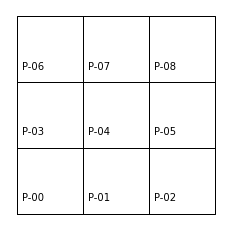

In [3]:
#from https://geographicdata.science/book/notebooks/04_spatial_weights.html#contiguity-weights
# Get points in a grid
l = np.arange(3)
xs, ys = np.meshgrid(l, l)
# Set up store
polys = []
# Generate polygons
for x, y in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    polys.append(poly)
# Convert to GeoSeries
polys = gpd.GeoSeries(polys)
sgrid = gpd.GeoDataFrame({'geometry': polys, 
                        'id': ['P-%s'%str(i).zfill(2) for i in range(len(polys))]})

#now plot
ax = sgrid.plot(facecolor='w', edgecolor='k')
[plt.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in sgrid['id']])]
ax.set_axis_off()
plt.show()

## Rook Contiguity <a name="rook"></a>

In chess, [the Rook](https://en.wikipedia.org/wiki/Rook_(chess)) can move horizontally or vertically, but _not_ diagonally. Using this rule for contiuity, the neighbours of P-04 in our simple grid above are:
- P-01
- P-03
- P-05
- P-07

To specify this for our simple grid using _pysal_ we use [the `Rook` function](https://pysal.org/libpysal/generated/libpysal.weights.Rook.html#libpysal.weights.Rook) (from the `weights.contiguity` module). This function:

> Construct[s] a weights object from a collection of pysal polygons that share at least one edge. 

Thus, we have our formal definition of rook contiguity; polygons must share an edge to be deemed neighbours (sharing a vertex alone is insufficient).

In [4]:
wRook = weights.contiguity.Rook.from_dataframe(sgrid)

We used the `.from_dataframe` helper function here as we created `sgrid` as a GeoPandas GeoDataFrame above. 

Now we have created our weights object, we can check which grid cells are neighbours using the `.neighbours` method: 

In [5]:
wRook.neighbors

{0: [1, 3],
 1: [0, 2, 4],
 2: [1, 5],
 3: [0, 4, 6],
 4: [1, 3, 5, 7],
 5: [8, 2, 4],
 6: [3, 7],
 7: [8, 4, 6],
 8: [5, 7]}

Note that in this dictionary, the value for the key `4` is a list containing the values `1`, `3`, `5`, and `7`. This is indicating to us that the grid cell with index 4 has four neighbours, the grid cells with indexes as given in the list. 

Check you understand that the structure of this dict, for example that you understand grid cell with index 1 has three neighbours (0, 2, 4) and that these indeed are grid cells that share a common edge. 

To get the actual `id`s of the grid cells, we need to use the `ids` argument to indicate which Series of the GeoDataFrame should be used to label the polygons:

In [6]:
wRook = weights.contiguity.Rook.from_dataframe(sgrid, ids=sgrid['id'].tolist())
wRook.neighbors

{'P-00': ['P-03', 'P-01'],
 'P-01': ['P-00', 'P-02', 'P-04'],
 'P-02': ['P-05', 'P-01'],
 'P-03': ['P-00', 'P-04', 'P-06'],
 'P-04': ['P-05', 'P-03', 'P-01', 'P-07'],
 'P-05': ['P-08', 'P-02', 'P-04'],
 'P-06': ['P-07', 'P-03'],
 'P-07': ['P-08', 'P-04', 'P-06'],
 'P-08': ['P-07', 'P-05']}

Check you can see that this dict has the same structure as before, but now using polygon (string) ids rather than indexes (integers). 

We can also check the _weight_ of the neighbour relations, using the `.weights` method:

In [7]:
wRook.weights

{'P-00': [1.0, 1.0],
 'P-01': [1.0, 1.0, 1.0],
 'P-02': [1.0, 1.0],
 'P-03': [1.0, 1.0, 1.0],
 'P-04': [1.0, 1.0, 1.0, 1.0],
 'P-05': [1.0, 1.0, 1.0],
 'P-06': [1.0, 1.0],
 'P-07': [1.0, 1.0, 1.0],
 'P-08': [1.0, 1.0]}

This shows that all weights are equal to 1. This makes sense because **contiguity weights are binary**; grid cells are either neighbours or they are not (we'll see variations in the weight or 'strength' of neighbours in other classes of weighting). 

Let's visualise the neighbour relations in the simple grid `wRook` spatial weights object:

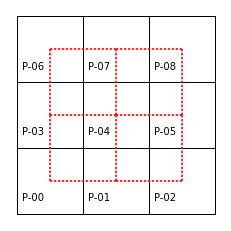

In [8]:
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
wRook.plot(sgrid, indexed_on='id', edge_kws=dict(color='r', linestyle=':'), ax =ax)
sgrid.plot(facecolor='w', edgecolor='k', ax=ax)
[ax.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in sgrid['id']])]
plt.gca().set_axis_off()

Hopefully you can see how the `wRook` spatial weights object does indeed represent the Rook rule for contiguity. 

Remember above we said that we often use a matrix to define neighbourhood relations - the spatial weights object is essentially a matrix. We can view the matrix using the `.full` method: 

In [9]:
wRook.full()

(array([[0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.]]),
 ['P-00', 'P-01', 'P-02', 'P-03', 'P-04', 'P-05', 'P-06', 'P-07', 'P-08'])

We can make this look nearer and 'more matrix-like' with some helper code:

In [10]:
wRookmat = pd.DataFrame(*wRook.full()).astype(int)
wRookmat.columns = list(wRookmat.index)
wRookmat

,P-00,P-01,P-02,P-03,P-04,P-05,P-06,P-07,P-08
P-00,0,1,0,1,0,0,0,0,0
P-01,1,0,1,0,1,0,0,0,0
P-02,0,1,0,0,0,1,0,0,0
P-03,1,0,0,0,1,0,1,0,0
P-04,0,1,0,1,0,1,0,1,0
P-05,0,0,1,0,1,0,0,0,1
P-06,0,0,0,1,0,0,0,1,0
P-07,0,0,0,0,1,0,1,0,1
P-08,0,0,0,0,0,1,0,1,0


From this, we can see again that contiguity spatial weights are binary; a polygon either is (`1`) or is not (`0`) a neighbour. 

The matrix is read 'across': each spatial location (polygon) is represented in the matrix by a row (*i*), and the potential neighbors by the columns (*j*). So as above, we can see that polygon P-04 has neighbours P-01, P-03, P-05 and P-07 by reading across the row indexed by **P-04**.

Other useful methods are available for quantifying the number of neighbours specified by the spatial weights matrix: 

In [11]:
wRook.nonzero

24

In [12]:
wRook.pct_nonzero   #24/(9*9)

29.62962962962963

In [13]:
wRook.cardinalities

{'P-00': 2,
 'P-01': 3,
 'P-02': 2,
 'P-03': 3,
 'P-04': 4,
 'P-05': 3,
 'P-06': 2,
 'P-07': 3,
 'P-08': 2}

The `cardinalities` method returns a dictionary containing the counts of neighbours. We can use this to plot a histogram of the distribution of the number of neighbours in our data:

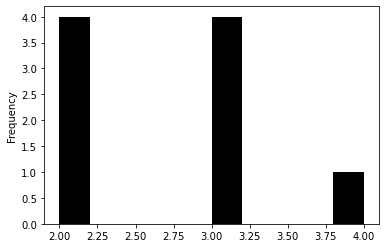

In [14]:
pd.Series(wRook.cardinalities).plot.hist(color='k');

Checking the distribution is useful to quickly spot asymmetries in the number of neighbors. This is relevant when using spatial weights in for other analytical techniques like autocorrelation analysis or spatial regression. 

## Queen Contiguity <a name="queen"></a>

In chess, [the Queen](https://en.wikipedia.org/wiki/Queen_(chess)) can move horizontally or vertically _and_ diagonally. Using this rule for contiuity, the neighbours of P-04 in our simple grid above are:
- P-00
- P-01
- P-02
- P-03
- P-04
- P-05
- P-06
- P-07
- P-08

To specify this for our simple grid using _pysal_ we use [the `Queen` function](https://pysal.org/libpysal/generated/libpysal.weights.Queen.html#libpysal.weights.Queen) (from the `weights.contiguity` module). This function:

> Construct[s] a weights object from a collection of pysal polygons that share at least one vertex.

Thus, we have our formal definition of queen contiguity; polygons must share a vertex to be deemed neighbours (and sharing an edge automatically means that at least two vertexes are shared). 

In [15]:
wQueen = weights.contiguity.Queen.from_dataframe(sgrid, ids=sgrid['id'].tolist())

The `Queen` method used in the same way as the `Rook` method, but we can see the difference in the spatial weights object created: 

In [16]:
wQueen.neighbors

{'P-00': ['P-04', 'P-03', 'P-01'],
 'P-01': ['P-04', 'P-00', 'P-02', 'P-03', 'P-05'],
 'P-02': ['P-05', 'P-04', 'P-01'],
 'P-03': ['P-04', 'P-06', 'P-07', 'P-00', 'P-01'],
 'P-04': ['P-01', 'P-08', 'P-06', 'P-07', 'P-00', 'P-02', 'P-03', 'P-05'],
 'P-05': ['P-04', 'P-08', 'P-07', 'P-02', 'P-01'],
 'P-06': ['P-07', 'P-04', 'P-03'],
 'P-07': ['P-04', 'P-08', 'P-06', 'P-03', 'P-05'],
 'P-08': ['P-07', 'P-04', 'P-05']}

In [17]:
wQueen.weights

{'P-00': [1.0, 1.0, 1.0],
 'P-01': [1.0, 1.0, 1.0, 1.0, 1.0],
 'P-02': [1.0, 1.0, 1.0],
 'P-03': [1.0, 1.0, 1.0, 1.0, 1.0],
 'P-04': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'P-05': [1.0, 1.0, 1.0, 1.0, 1.0],
 'P-06': [1.0, 1.0, 1.0],
 'P-07': [1.0, 1.0, 1.0, 1.0, 1.0],
 'P-08': [1.0, 1.0, 1.0]}

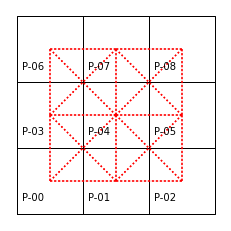

In [18]:
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
wQueen.plot(sgrid, indexed_on='id', edge_kws=dict(color='r', linestyle=':'), ax =ax)
sgrid.plot(facecolor='w', edgecolor='k', ax=ax)
[ax.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in sgrid['id']])]
plt.gca().set_axis_off()

In [19]:
wQueenmat = pd.DataFrame(*wQueen.full()).astype(int)
wQueenmat.columns = list(wQueenmat.index)
wQueenmat

,P-00,P-01,P-02,P-03,P-04,P-05,P-06,P-07,P-08
P-00,0,1,0,1,1,0,0,0,0
P-01,1,0,1,1,1,1,0,0,0
P-02,0,1,0,0,1,1,0,0,0
P-03,1,1,0,0,1,0,1,1,0
P-04,1,1,1,1,0,1,1,1,1
P-05,0,1,1,0,1,0,0,1,1
P-06,0,0,0,1,1,0,0,1,0
P-07,0,0,0,1,1,1,1,0,1
P-08,0,0,0,0,1,1,0,1,0


In [20]:
wQueen.nonzero

40

In [21]:
wQueen.pct_nonzero

49.382716049382715

In [22]:
wQueen.cardinalities

{'P-00': 3,
 'P-01': 5,
 'P-02': 3,
 'P-03': 5,
 'P-04': 8,
 'P-05': 5,
 'P-06': 3,
 'P-07': 5,
 'P-08': 3}

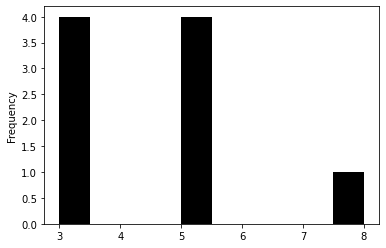

In [23]:
pd.Series(wQueen.cardinalities).plot.hist(color='k');

In comparing the Rook and Queen rules for contiguity for our simple square grid, we can see that there is quite a difference between the two in terms of the definition of neighbors (with many more neighbours defined for the Queen rule than the Rook). However, for irregular polygons - like most areal units for spatial data in the real world - differences in the definition of neighbours between the two rule will be small. 

Thus, [as Anselin suggests](https://geodacenter.github.io/workbook/4a_contig_weights/lab4a.html#queen-contiguity):

> In order to deal with potential inaccuracies in the polygon file (such as rounding errors), using the queen criterion is recommended in practice. 

## London Boroughs <a name="london"></a>

So let's look at some real world data, for London Boroughs. 

We should have successfully loaded a shapefile into the `boro` object in the Setup. Let's check what these data look like:

In [24]:
boros.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."


<AxesSubplot:>

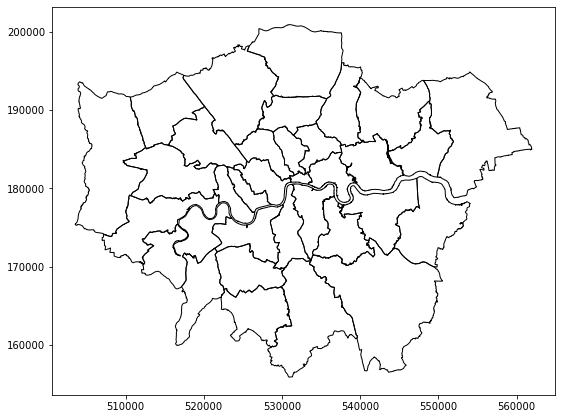

In [25]:
f, ax = plt.subplots(1, figsize=(9, 9))
boros.plot(ax=ax, facecolor='none', edgecolor='black')

Because we read the Boroughs data as a GeoDataFrame, we can create a spatial weights object using the Queen contiguity rule as before: 

In [26]:
print(type(boros))
borosQW = weights.contiguity.Queen.from_dataframe(boros, ids=boros['NAME'].tolist())

<class 'geopandas.geodataframe.GeoDataFrame'>


In [27]:
borosQWmat = pd.DataFrame(*borosQW.full()).astype(int)
borosQWmat.columns = list(borosQWmat.index)
borosQWmat

,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,...,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
Barnet,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Bexley,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Brent,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
Bromley,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
Camden,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
City of London,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
Croydon,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
Ealing,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enfield,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


This is a much bigger matrix than our simple grid, and so it is difficult to see all the combinations. In this case we could visualise using a seaborn heatmap:

<AxesSubplot:>

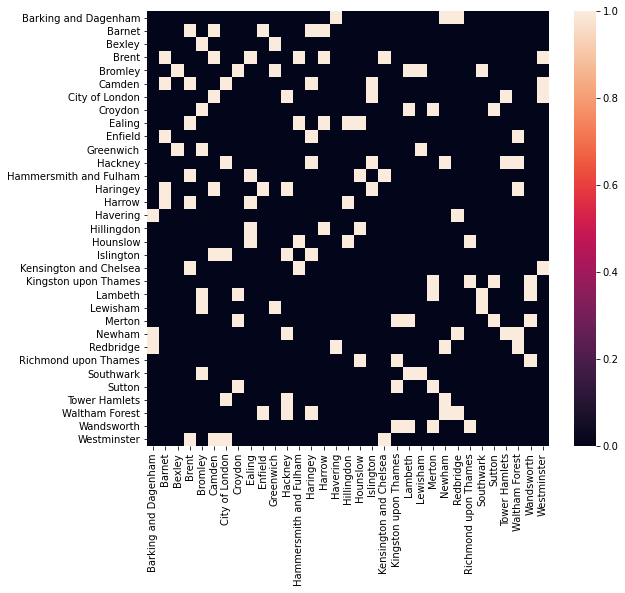

In [28]:
f, ax = plt.subplots(1, figsize=(9, 8))
sns.heatmap(borosQWmat)

Or even better, let's visualise in spatial context: 

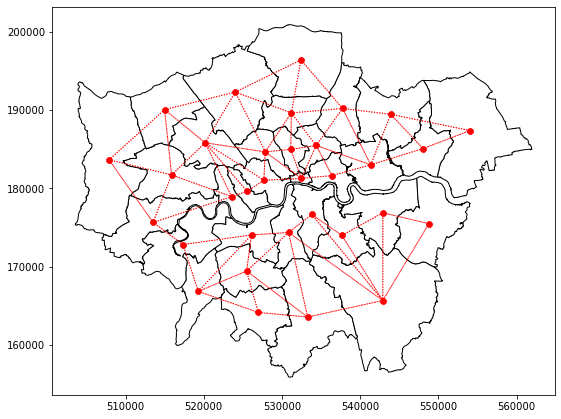

In [29]:
f, ax = plt.subplots(1, figsize=(9, 9))
boros.plot(ax=ax, edgecolor='k', facecolor='w')
borosQW.plot(boros, indexed_on='NAME', ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(color='r', marker='8'))
plt.show()

Note how the Thames prevents common vertices for most boroughs either side of the river.

In the Introduction, we highlighted that one question we might have is:

> How many London Boroughs are neighbours of Southwark?

We could find that out using the `cardinalities` method:

In [30]:
borosQW.cardinalities

{'Barking and Dagenham': 3,
 'Barnet': 5,
 'Bexley': 2,
 'Brent': 7,
 'Bromley': 6,
 'Camden': 6,
 'City of London': 5,
 'Croydon': 4,
 'Ealing': 5,
 'Enfield': 3,
 'Greenwich': 3,
 'Hackney': 6,
 'Hammersmith and Fulham': 4,
 'Haringey': 6,
 'Harrow': 4,
 'Havering': 2,
 'Hillingdon': 3,
 'Hounslow': 4,
 'Islington': 4,
 'Kensington and Chelsea': 3,
 'Kingston upon Thames': 4,
 'Lambeth': 5,
 'Lewisham': 3,
 'Merton': 5,
 'Newham': 5,
 'Redbridge': 4,
 'Richmond upon Thames': 3,
 'Southwark': 3,
 'Sutton': 3,
 'Tower Hamlets': 3,
 'Waltham Forest': 5,
 'Wandsworth': 4,
 'Westminster': 4}

Or we could use the `neighbours` method, passing the name of the Borough we want to know about:

In [31]:
borosQW.neighbors['Southwark']

['Bromley', 'Lewisham', 'Lambeth']

Let's compare the Queen rule to the Rook rule to see what differences there are in how neighbours are defined:

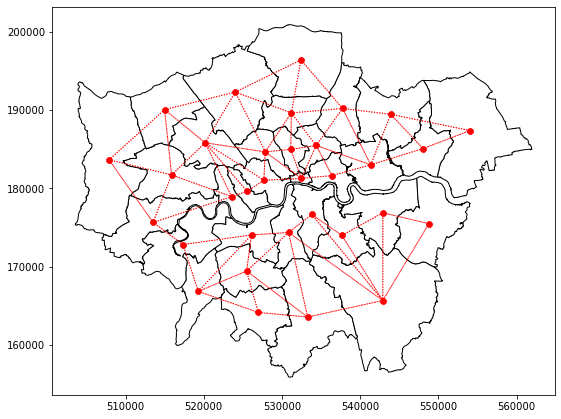

In [32]:
borosRW = weights.contiguity.Rook.from_dataframe(boros, ids=boros['NAME'].tolist())

f, ax = plt.subplots(1, figsize=(9, 9))
boros.plot(ax=ax, edgecolor='k', facecolor='w')
borosRW.plot(boros, indexed_on='NAME', ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(color='r', marker='8'))
plt.show()

This looks very similar. Let's compare further between between the two rules: 

In [33]:
borosRW.nonzero

136

In [34]:
borosQW.nonzero

136

Same number of neighbours are defined. Let's look at the distribution:

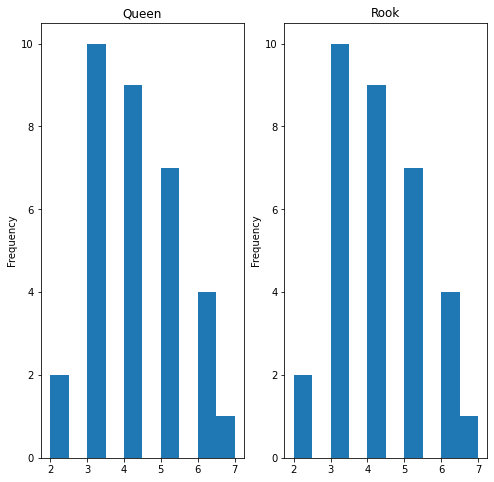

In [35]:
f, axs = plt.subplots(1, 2, figsize=(8, 8))
pd.Series(borosQW.cardinalities).plot(kind='hist', ax=axs[0], title="Queen");
pd.Series(borosRW.cardinalities).plot(kind='hist', ax=axs[1], title="Rook");

The distribution looks identical. 

Finally, let's plot a heatmap of the weights matrices side-by-side to compare. First we convert the Rook spatial weights matrix to a Pandas DataFrame, then we can plot with Seaborn.

In [36]:
borosRWmat = pd.DataFrame(*borosRW.full()).astype(int)
borosRWmat.columns = list(borosRWmat.index)
borosRWmat

,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,...,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
Barnet,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Bexley,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Brent,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
Bromley,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
Camden,0,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
City of London,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
Croydon,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
Ealing,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enfield,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Text(0.5, 1.0, 'Rook')

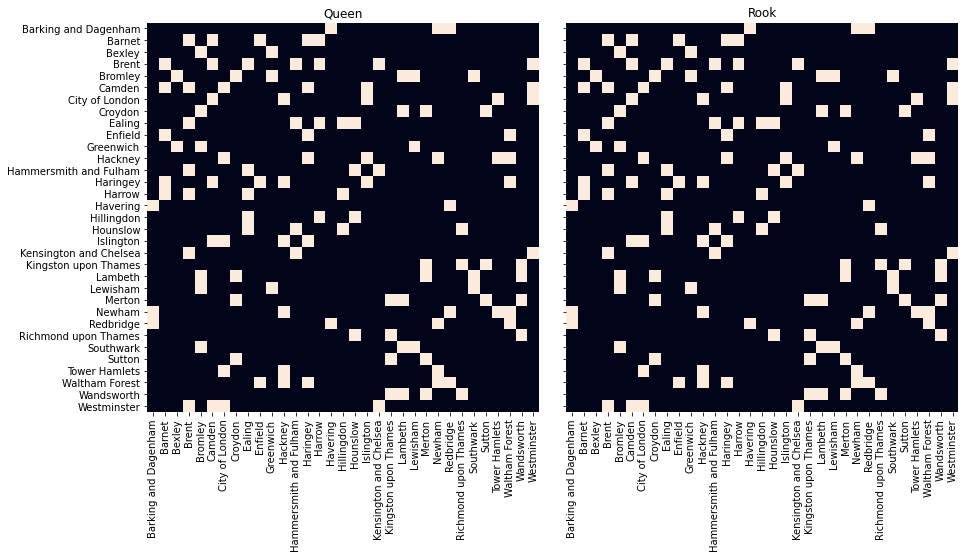

In [37]:
f, axs = plt.subplots(1,2, figsize=(12, 6), sharey=True)
plt.tight_layout()
sns.heatmap(borosQWmat, ax=axs[0], cbar=None)
sns.heatmap(borosRWmat, ax=axs[1], cbar=None)
axs[0].set_title('Queen')
axs[1].set_title('Rook')

As noted above, the difference between Rook and Queen rules for real-world data is usually very small, and in this case there appears to be no difference. 

The notion of contiguity weights for polygons should now be clear - neighbours are defined by shared edges and/or vertices. But what about if we want to create contiguity weights for points? This is possible, but first requires an intermediate step of creating a voronoi diagram, and then creating a spatial weights object using the Thiessen polygons. This is explored in the notebook examining spatial weights with John Snow data. 

Here, we will move on to consider a different kind of spatial weight.

# Distance-Based Weights <a name="distance"></a>

Alternative to considering contiguity, we could use distance as a means to establish neighbours and spatial weights. Usually, this is done by creating a matrix that expresses distances between all pairs of observations. This matrix is then provided to a function to define neighbours and spatial weights. PySAL provides a variety of functions that could be used. Here, we'll focus on two primary functions:
1. K Nearest Neighbours (KNN)
2. Kernel Weights

Aside other issues regarding measurement of distance (e.g. great circle), one issue that arises with distance-based weights is how to measure the distance between polygon objects. PySAL uses a 'representative point' for polygons, defining their “center of mass” or centroid. [Specifically](https://geographicdata.science/book/notebooks/04_spatial_weights.html#knn-weights):

> The centroids are attributes of the polygon shapes that PySAL calculates from the spatial information stored in the GeoDataFrame. 

We can see where these centroids are for the London Boroughs shapefile as follows:

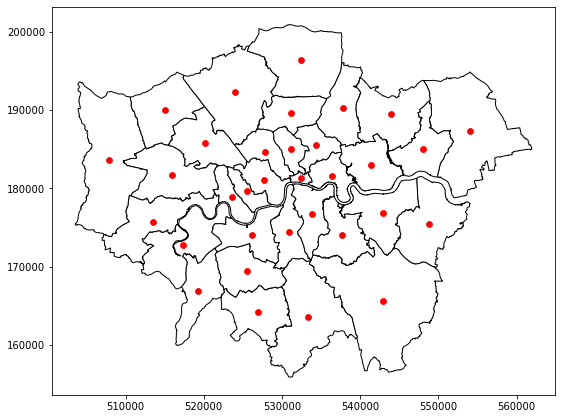

In [38]:
dummy= weights.contiguity.Rook.from_dataframe(boros)
f, ax = plt.subplots(1, figsize=(9, 9))
boros.plot(ax=ax, edgecolor='k', facecolor='w')
dummy.plot(boros,  ax=ax, 
        edge_kws=dict(linewidth=0),
        node_kws=dict(color='r', marker='8'))
plt.show()

We won't worry about exactly _how_ PySAL defines these centroids, but we do need to remember that it is the distance between these locations that is being used to establish neighbors and spatial weights (for example, for understanding why some neighbors are are not reciprocal, as we'll see below).   

## K Nearest Neighbours <a name="KNN"></a>

KNN stands for 'K Nearest Neighbours'. KNN defines the neighbors of a particular location as the _k_ with smallest distance (i.e. the nearest), where the user specifies the (integer) value of _k_. By default the [PySAL KNN weights function](https://pysal.org/libpysal/generated/libpysal.weights.KNN.html#libpysal.weights.KNN) assumes euclidean distances (not e.g. Great Circle) and a _k_ of 2. 

Let's create a spatial weights object for the London Boroughs, using `k=3` and specfying locations ids using the `NAME` column of the `boros` GeoDataFrame:

In [39]:
borosKNN3 = weights.distance.KNN.from_dataframe(boros, k=3, ids=boros['NAME'].tolist())

The spatial weights matrix produced is large because we have so many Boroughs:

In [40]:
borosKNN3mat = pd.DataFrame(*borosKNN3.full()).astype(int)
borosKNN3mat.columns = list(borosKNN3mat.index)
borosKNN3mat

,Kingston upon Thames,Croydon,Bromley,Hounslow,Ealing,Havering,Hillingdon,Harrow,Brent,Barnet,...,Kensington and Chelsea,Westminster,Camden,Tower Hamlets,Islington,Hackney,Haringey,Newham,Barking and Dagenham,City of London
Kingston upon Thames,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Croydon,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bromley,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hounslow,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ealing,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Havering,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Hillingdon,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Harrow,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
Brent,0,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
Barnet,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0


Note that as for contiguity weights, the spatial weights are all binary; either a borough is (1) or is not (0) a neighbour. 

A Seaborn heatmap makes is easier to visualise the entire matrix:

<AxesSubplot:>

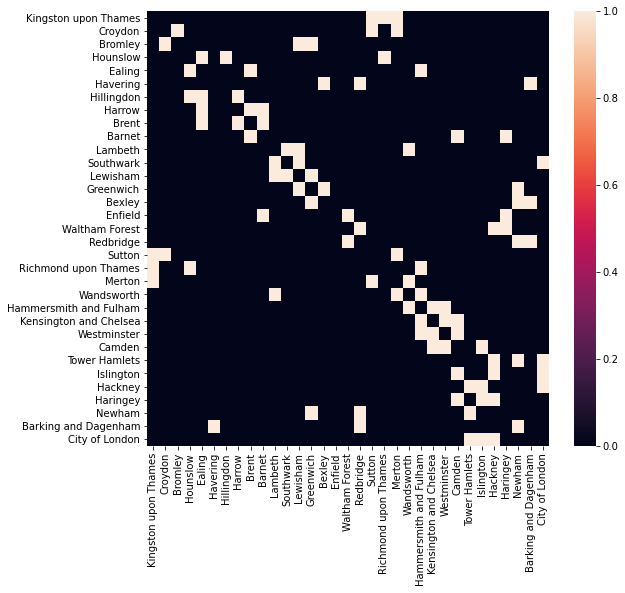

In [41]:
f, ax = plt.subplots(1, figsize=(9, 8))
sns.heatmap(borosKNN3mat)

Note how each row has three light cells. This is because by definition for `k=3`, each borough has exactly three neighbours. We can check this using the `cardinalities` method:

In [42]:
borosKNN3.cardinalities

{'Kingston upon Thames': 3,
 'Croydon': 3,
 'Bromley': 3,
 'Hounslow': 3,
 'Ealing': 3,
 'Havering': 3,
 'Hillingdon': 3,
 'Harrow': 3,
 'Brent': 3,
 'Barnet': 3,
 'Lambeth': 3,
 'Southwark': 3,
 'Lewisham': 3,
 'Greenwich': 3,
 'Bexley': 3,
 'Enfield': 3,
 'Waltham Forest': 3,
 'Redbridge': 3,
 'Sutton': 3,
 'Richmond upon Thames': 3,
 'Merton': 3,
 'Wandsworth': 3,
 'Hammersmith and Fulham': 3,
 'Kensington and Chelsea': 3,
 'Westminster': 3,
 'Camden': 3,
 'Tower Hamlets': 3,
 'Islington': 3,
 'Hackney': 3,
 'Haringey': 3,
 'Newham': 3,
 'Barking and Dagenham': 3,
 'City of London': 3}

And finally we can visualise neighbours spatially:

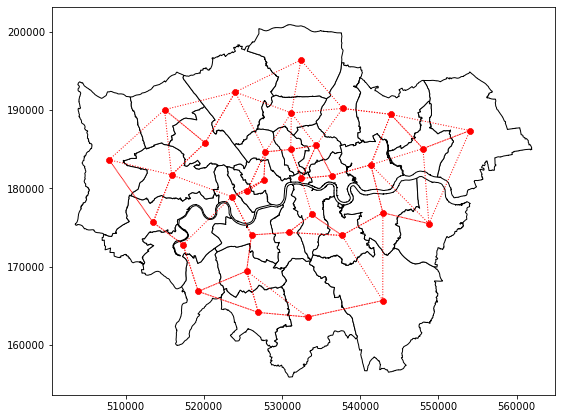

In [43]:
f, ax = plt.subplots(1, figsize=(9, 9))
boros.plot(ax=ax, edgecolor='k', facecolor='w')
borosKNN3.plot(boros, indexed_on='NAME', ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(color='r', marker='8'))
plt.show()

To compare this map to our previous map for the `Queen` contiguity, we'll write a function (that we'll use again later): 

In [44]:
def DoublePlot(axs, swo, swolab, blab=False, xlims=None, ylims=None):
    
    boros.plot(ax=axs, edgecolor='k', facecolor='w')
    swo.plot(boros, indexed_on='NAME', ax=axs, 
                   edge_kws=dict(color='r', linestyle=':', linewidth=1),
                   node_kws=dict( marker=''))
    
    if(blab):
        for index, row in boros.iterrows():
            #help from here https://stackoverflow.com/a/51689106
            b=row['NAME']
            axs.annotate('{0}\n{1}'.format(b,swo.neighbors[b]),
                         xy=(boros.centroid[index].coords[0][0], boros.centroid[index].coords[0][1]),
                         clip_on=True)

    axs.set_title(swolab)
    axs.set_xlim(xlims)
    axs.set_ylim(ylims)   

Now use the function to compare the spatial weights functions:

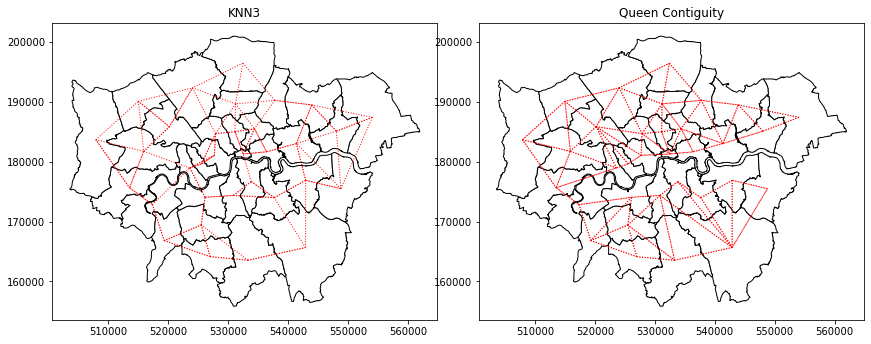

In [45]:
f, ax = plt.subplots(1,2, figsize=(12, 12))
plt.tight_layout()

DoublePlot(ax[0], borosKNN3, "KNN3")
DoublePlot(ax[1], borosQW, "Queen Contiguity")

plt.show()

Note how **`KNN` does not care about shared borders (edges or vertices)** - Boroughs that are either side of the Thames may now be defined as neighbours if the polygon centroid has a smalle enough distance. This can lead to differently defined neighbours. 

For example, compare the neighbours of Southwark for `KNN3` vs `Queen` spatial weights:

In [46]:
borosKNN3.neighbors['Southwark']  

['Lambeth', 'Lewisham', 'City of London']

In [47]:
borosQW.neighbors['Southwark']  

['Bromley', 'Lewisham', 'Lambeth']

And we can visualise the difference spatially:

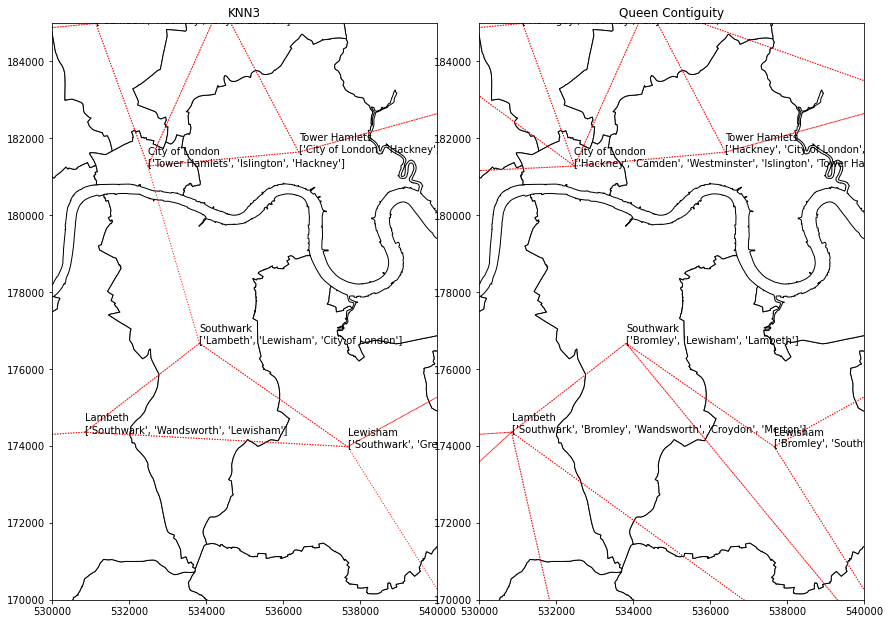

In [48]:
Southwark_xlims=[530000, 540000]
Southwark_ylims=[170000, 185000]

f, ax = plt.subplots(1,2, figsize=(12, 12))
plt.tight_layout()
DoublePlot(ax[0], borosKNN3, "KNN3", blab=True, xlims=Southwark_xlims, ylims=Southwark_ylims)
DoublePlot(ax[1], borosQW, "Queen Contiguity", blab=True, xlims=Southwark_xlims, ylims=Southwark_ylims)
plt.show()

The labels above are the list of neighbours for the named Borough. 

So, which approach to defining neighbours is appropriate? Well, that might depend on whether you think (for the issue you are investigating) boroughs on either side of the Thames are indeed neighbours. 

Another thing to note from the last visualisation is that while some neighbour-relations are reciprocal, others are only one-way. For example:
- City of London and Tower Hamlets are reciprocal neighbors for `KNN3` but not `Queen` 
- City of London is a neighbour of Southwark (but **not** _vice versa_ ) for `KNN3`, and there is no neighbour relationship (in either direction) between these boroughs for `Queen`

We can look for similar differences elsewhere across London:

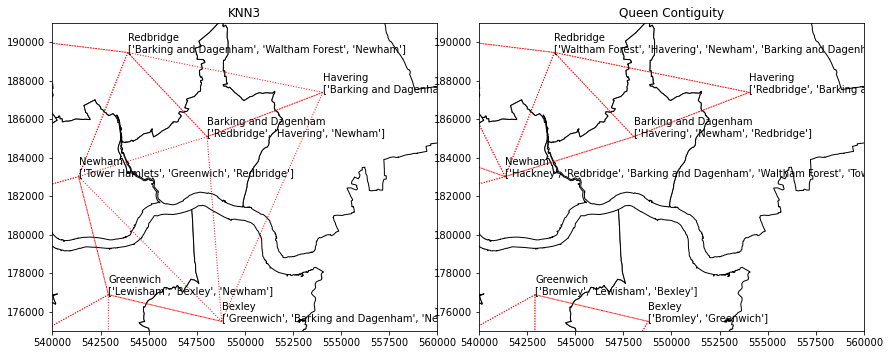

In [49]:
Barking_xlims=[540000, 560000]
Barking_ylims=[175000, 191000]

f, ax = plt.subplots(1,2, figsize=(12, 12))
plt.tight_layout()
DoublePlot(ax[0], borosKNN3, "KNN3", blab=True, xlims=Barking_xlims, ylims=Barking_ylims)
DoublePlot(ax[1], borosQW, "Queen Contiguity", blab=True, xlims=Barking_xlims, ylims=Barking_ylims)
plt.show()

## Kernel <a name="kernel"></a>

All the techniques for specifying spatial neighbour relations so far have been binary: locations are either neighbours or they are not. However, for locations that are neighbours we could also consider varying the weight or 'strength' of the relationship. **Kernel weights** allows this latter approach. 

In statistics, a [kernel](https://en.wikipedia.org/wiki/Kernel_(statistics)) is a [window function](https://en.wikipedia.org/wiki/Window_function), meaning that beyond some distance (the 'window' or 'bandwidth') a weight will be zero. Within the window the weight is defined by the kernel function. 

PySAL offers several kernel functions, all of which exhibit [distance decay](https://en.wikipedia.org/wiki/Distance_decay). Thus, these kernel functions encode Tobler's first law; observations closer to a location have larger valued weights than more distant observations. 

Kernel functions [available in PySAL](https://pysal.org/libpysal/generated/libpysal.weights.Kernel.html) are:
- triangular
- uniform
- quadratic ('Epanechnikov')
- quartic
- gaussian

The [following figure](https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Kernels.svg/600px-Kernels.svg.png) should help to visualise the [different types of kernel](https://en.wikipedia.org/wiki/Kernel_(statistics)#Kernel_functions_in_common_use): 

<center><img src="../../data/img/600px-Kernels.png" width=600/>[<a href="https://commons.wikimedia.org/wiki/File:Kernels.svg" target=_blank>Source</a> | <a href="https://creativecommons.org/licenses/by-sa/3.0/deed.en" target=_blank>License</a>]</center>   

How to read [the figure](https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Kernels.svg/600px-Kernels.svg.png) above:
- 0 is centred on the focal location
- line show the weight (on y-axis) for a neighbour at any given distance (on x-axis) from the focal location

For observations separated by distances larger than the `bandwidth`, the weights are set to zero for all kernels _except_ the Gaussan (which is [unbounded](https://pysal.org/libpysal/generated/libpysal.weights.Kernel.html)). Bandwidth is in the units of the projection - the plots above are abstract, but in our London example we have a projection in metres.

[In PySAL](https://geographicdata.science/book/notebooks/04_spatial_weights.html#kernel-weights):

> The default values for kernels are to use a triangular kernel with a bandwidth distance equal to the maximum knn=2 distance for all observations. The latter implies a so-called fixed bandwidth were all observations use the same distance for the cut-off.

In PySAL we use the [`Kernel` function](https://pysal.org/libpysal/generated/libpysal.weights.Kernel.html) to create spatial weights objects using kernel functions. 

Let's create a spatial weights object using the defaults (triangular kernel with bandwidth specified by *KNN=2*) and we'll specify Borough labels for ids: 

In [50]:
borosK = weights.distance.Kernel.from_dataframe(boros, function='gaussian', ids=boros['NAME'].tolist())

Let's look at the spatial weights matrix produced:

In [51]:
borosKmat = round(pd.DataFrame(*borosK.full()),3)   #note, not focing to int!
borosKmat.columns = list(borosKmat.index)
borosKmat

,Kingston upon Thames,Croydon,Bromley,Hounslow,Ealing,Havering,Hillingdon,Harrow,Brent,Barnet,...,Kensington and Chelsea,Westminster,Camden,Tower Hamlets,Islington,Hackney,Haringey,Newham,Barking and Dagenham,City of London
Kingston upon Thames,0.399,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Croydon,0.000,0.399,0.254,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Bromley,0.000,0.254,0.399,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Hounslow,0.000,0.000,0.000,0.399,0.327,0.000,0.255,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Ealing,0.000,0.000,0.000,0.327,0.399,0.000,0.291,0.287,0.338,0.000,...,0.253,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Havering,0.000,0.000,0.000,0.000,0.000,0.399,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.329,0.000
Hillingdon,0.000,0.000,0.000,0.255,0.291,0.000,0.399,0.260,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Harrow,0.000,0.000,0.000,0.000,0.287,0.000,0.260,0.399,0.323,0.266,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Brent,0.000,0.000,0.000,0.000,0.338,0.000,0.000,0.323,0.399,0.306,...,0.291,0.275,0.301,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Barnet,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.266,0.306,0.399,...,0.000,0.000,0.283,0.000,0.245,0.000,0.303,0.000,0.000,0.000


Note how, different from contiguity and KNN weights, **the spatial weights are continous**. Kernel weights are _not_ binary, rather they take a continuous value based on distance and dependent on the kernel function being used. With this approach we specify not only which Borough are neighbours but also which are more related to one another (by distance) than others.  

A Seaborn heatmap makes is easier to visualise the entire matrix:

<AxesSubplot:>

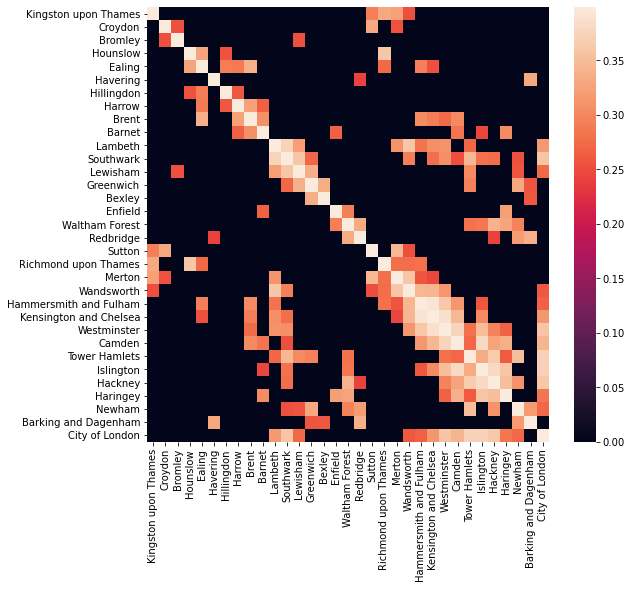

In [52]:
f, ax = plt.subplots(1, figsize=(9, 8))
sns.heatmap(borosKmat)

Note how different this heatmap looks from the others we have seen in this notebook. The colour shades represent the continuous nature of the spatial weights from the kernel function. 

The number of neighbours defined by a kernel function varies depending on the bandwidth specified (and the function used). In this case we have used the defaults (`triangular` kernel with bandwidth specified by *KNN=2*), giving us the following number of neighbours:

In [53]:
borosK.cardinalities

{'Kingston upon Thames': 5,
 'Croydon': 4,
 'Bromley': 3,
 'Hounslow': 4,
 'Ealing': 8,
 'Havering': 3,
 'Hillingdon': 4,
 'Harrow': 5,
 'Brent': 8,
 'Barnet': 7,
 'Lambeth': 10,
 'Southwark': 13,
 'Lewisham': 8,
 'Greenwich': 7,
 'Bexley': 3,
 'Enfield': 4,
 'Waltham Forest': 8,
 'Redbridge': 6,
 'Sutton': 5,
 'Richmond upon Thames': 7,
 'Merton': 9,
 'Wandsworth': 11,
 'Hammersmith and Fulham': 12,
 'Kensington and Chelsea': 12,
 'Westminster': 13,
 'Camden': 12,
 'Tower Hamlets': 13,
 'Islington': 12,
 'Hackney': 11,
 'Haringey': 10,
 'Newham': 10,
 'Barking and Dagenham': 6,
 'City of London': 14}

Note that the minimum number of neighbours is 3, even though the default specifies KNN=2. This is because for some reason the focal location is included in the neighbour count (k attribute) of spatial weights objects created using the PySAL Kernel function. 

We can check what bandwidth was calculated from the _bandwidth_ attribute (specifying that we only want to see the first five values):

In [54]:
borosK.bandwidth[0:5]

array([[10343.92142192],
       [10343.92142192],
       [10343.92142192],
       [10343.92142192],
       [10343.92142192]])

This bandwidth was specified based on the longest distance for all Boroughs to have a minimum of two neighbours. (the KNN=2 bit of the default setting). So the bandwidth as been dynamically calculated based on the minimum number of neighbours we think our Boroughs should have. 

But remember that we can over-ride this and specify the bandwidth explicitly ourselves. Let's see this by creating a new spatialweights object with a slightly smaller bandwidth (`10000` vs `10343`): 

In [55]:
borosKb10k = weights.distance.Kernel.from_dataframe(boros, bandwidth=10000, ids=boros['NAME'].tolist())
borosKb10k.bandwidth[0:5]

array([[10000.],
       [10000.],
       [10000.],
       [10000.],
       [10000.]])

Let's compare the two kernel spatial weights objects we've created in terms of the neighbours they specify. The following code selects five Boroughs for comparison, printing the corresponding value in the _cardinalities_ `dict`:

In [56]:
keys = ['Croydon', 'Bromley', 'Ealing', 'Redbridge', 'Havering']
for key in keys:
    print("KNN\t{0}\t{1}".format(key,borosK.cardinalities.get(key)))
    print("10k\t{0}\t{1}".format(key,borosKb10k.cardinalities.get(key)))

KNN	Croydon	4
10k	Croydon	4
KNN	Bromley	3
10k	Bromley	3
KNN	Ealing	8
10k	Ealing	8
KNN	Redbridge	6
10k	Redbridge	4
KNN	Havering	3
10k	Havering	2


From the output we can see:
- some Boroughs have the same number of neighbours in both cases 
- some Boroughs have fewer neighbours for the smaller bandwidth (10k) 

What about the weights of the neighbours? Let's compare the weights for the Borough of Southwark between the two objects we've created:

In [57]:
borosK['Southwark']

{'Wandsworth': 0.292702063177705,
 'Lambeth': 0.3733479145704088,
 'Kensington and Chelsea': 0.27789934363991164,
 'Westminster': 0.30594146919997495,
 'Camden': 0.2506581655082336,
 'Greenwich': 0.27115721395491116,
 'Southwark': 0.3989422804014327,
 'Lewisham': 0.35991419949636755,
 'City of London': 0.35826492962137435,
 'Tower Hamlets': 0.34460470060116755,
 'Newham': 0.25343057177897416,
 'Islington': 0.27920040656277095,
 'Hackney': 0.27696313360251007}

In [58]:
borosKb10k['Southwark']

{'Wandsworth': 0.18596361029766983,
 'Lambeth': 0.6233164357117554,
 'Kensington and Chelsea': 0.12039222265323646,
 'Westminster': 0.24635046129700666,
 'Camden': 0.0027616119419326957,
 'Greenwich': 0.09100767467032533,
 'Southwark': 1.0,
 'Lewisham': 0.5306296426230077,
 'City of London': 0.5202739347644476,
 'Tower Hamlets': 0.4402441977342336,
 'Newham': 0.014634289530552458,
 'Islington': 0.12609238152215052,
 'Hackney': 0.11629688348665712}

We can see that these differ slightly between the two bandwiths. Remember this is for the *triangular* kernel function, which looks like [the image](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Kernel_triangle.svg/600px-Kernel_triangle.svg.png) below, so that makes sense. 

<center><img src="../../data/img/600px-Kernel_triangle.png" width=600/>[<a href="https://commons.wikimedia.org/wiki/File:Kernel_triangle.svg" target=_blank>Source</a> | <a href="https://creativecommons.org/licenses/by-sa/3.0/deed.en" target=_blank>License</a>]</center>   

But what if we used the uniform function? (which looks like [the image](https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Kernel_uniform.svg/600px-Kernel_uniform.svg.png) below)

<center><img src="../../data/img/600px-Kernel_uniform.png" width=600/>[<a href="https://commons.wikimedia.org/wiki/File:Kernel_uniform.svg" target=_blank>Source</a> | <a href="https://creativecommons.org/licenses/by-sa/3.0/deed.en" target=_blank>License</a>]</center>   

In [59]:
borosU = weights.distance.Kernel.from_dataframe(boros, function='uniform', k=2, 
                                                ids=boros['NAME'].tolist())
borosUb10k = weights.distance.Kernel.from_dataframe(boros, function='uniform', bandwidth=10000, 
                                                    ids=boros['NAME'].tolist())

In [60]:
keys = ['Croydon', 'Bromley', 'Ealing', 'Redbridge', 'Havering']
for key in keys:
    print("KNN\t{0}\t{1}".format(key,borosU.cardinalities.get(key)))
    print("10k\t{0}\t{1}".format(key,borosUb10k.cardinalities.get(key)))

KNN	Croydon	4
10k	Croydon	4
KNN	Bromley	3
10k	Bromley	3
KNN	Ealing	8
10k	Ealing	8
KNN	Redbridge	6
10k	Redbridge	4
KNN	Havering	3
10k	Havering	2


We get the same neighbours as before. What about the weights?

In [61]:
borosU['Southwark']

{'Wandsworth': 0.5,
 'Lambeth': 0.5,
 'Kensington and Chelsea': 0.5,
 'Westminster': 0.5,
 'Camden': 0.5,
 'Greenwich': 0.5,
 'Southwark': 0.5,
 'Lewisham': 0.5,
 'City of London': 0.5,
 'Tower Hamlets': 0.5,
 'Newham': 0.5,
 'Islington': 0.5,
 'Hackney': 0.5}

In [62]:
borosUb10k['Southwark']

{'Wandsworth': 0.5,
 'Lambeth': 0.5,
 'Kensington and Chelsea': 0.5,
 'Westminster': 0.5,
 'Camden': 0.5,
 'Greenwich': 0.5,
 'Southwark': 0.5,
 'Lewisham': 0.5,
 'City of London': 0.5,
 'Tower Hamlets': 0.5,
 'Newham': 0.5,
 'Islington': 0.5,
 'Hackney': 0.5}

Now we see that *the weights for all neighbours is the same*. This makes sense for the _uniform_ function. 

Check you understand the reason why we get different weights for different bandwith with the _triangular_ function, but not the _uniform_ function. 

Let's visualise the differences spatially. First we create a function we can use to compare plots of neighbour weights below:

In [63]:
#function for plotting to use in loop below
#requires spatial weights objects are created with ids from boros['NAME']
def plotKernel(wKernel, gpDF, focal, myAx):
    
    #bins and their labels
    EQbins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    labs = []
    for i,val in enumerate(EQbins):
        if(i > 0):
            labs.append('{0}-{1}'.format(EQbins[i-1],EQbins[i]))
    
    #get the full matrix for this kernel 
    full_matrix, ids = wKernel.full() 
    full_matrix[full_matrix==0] = np.nan
    
    
    gpDF.plot(ax=myAx, facecolor='None', edgecolor='k')
    gpDF.assign(cats = pd.cut(full_matrix[ids.index(focal)],
                                    bins=EQbins, labels=labs, duplicates='drop')).plot('cats', ax=myAx,
                                                                                       cmap='viridis', alpha=0.8,
                                                           legend=True, legend_kwds={'loc': 'lower right'})
  
    #set titles
    myAx.set_title('{0}, {1}, k = {2}, b = {3}'.format(focal, wKernel.function, 
                                                       wKernel.k, int(wKernel.bandwidth[0])))
    myAx.get_legend().set_title("Weight")

    myAx.set_axis_off()

We can use this function to visualise the neighbour weights for a `focal` Borough and a given spatial weights object (`wKernel`). For example, to visualise neighbours of Southwark for the initial kernel spatial weights object we created above (using all defaults):

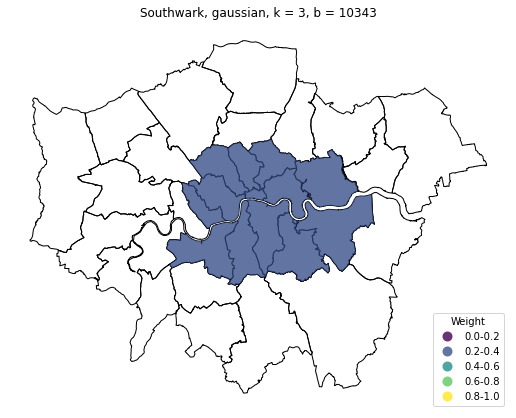

In [64]:
fig, ax = plt.subplots(1, figsize=(9, 9))
plotKernel(borosK, boros, 'Southwark', ax)

We can see the distance decay nature of the _triangular_ function here (remember that weights are based on distance to the _centroid_ of boroughs polygons).  

Let's use a loop to compare weights for different functions with the same bandwidth:

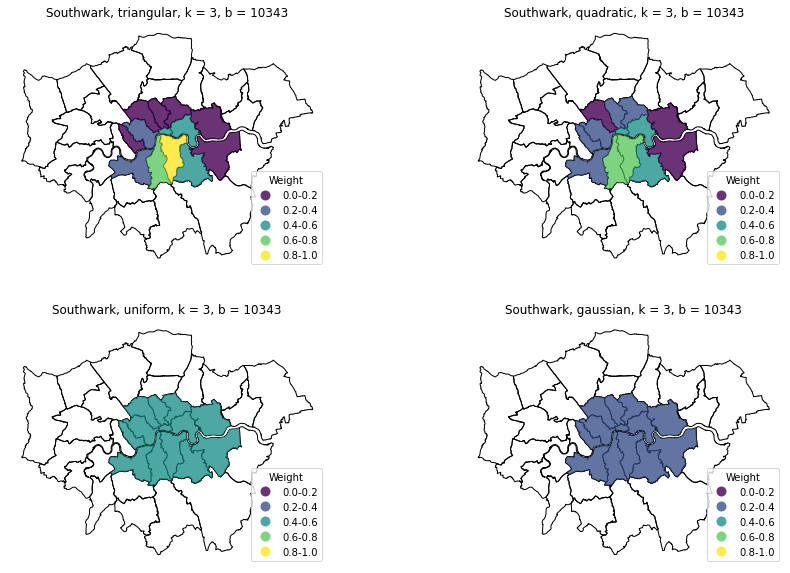

In [65]:
fig, axes = plt.subplots(2,2, figsize=(15, 10))

fList = ['triangular','quadratic','uniform','gaussian']

for ax, f in zip(axes.flat, fList):
    myKernel = weights.distance.Kernel.from_dataframe(boros, function=f, k=2, ids=boros['NAME'].tolist())

    plotKernel(myKernel, boros, 'Southwark', ax)

The same neighbours are specified each time (because the bandwidth is the same), but the weights (of 'neighbourlyness') vary depending on the kernel function being used. 

NB: Remember that in the titles above k is always 1 greater than the k specified in the code (because for some reason the focal location is included in the neighbour count of spatial weights objects created using the PySAL Kernel function). 

And let's look at another visualisation, this time for a single kernel function but different bandwidths each time:

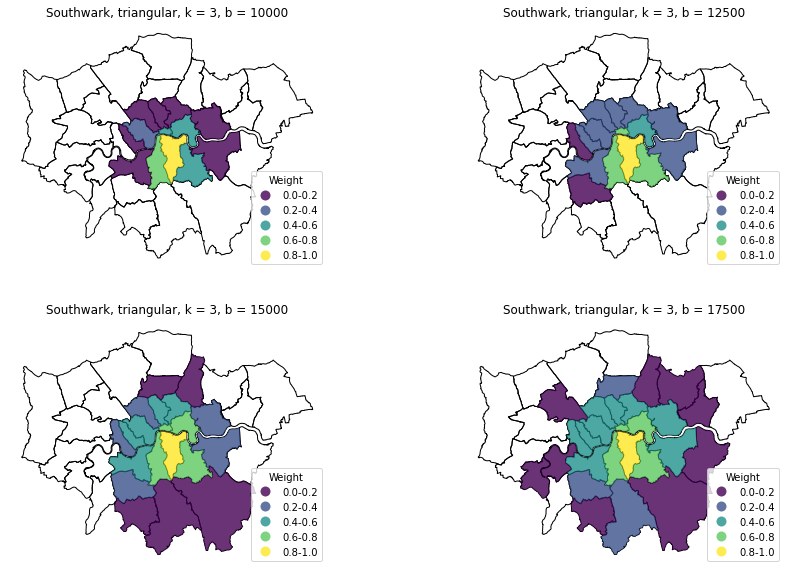

In [66]:
fig, axes = plt.subplots(2,2, figsize=(15, 10))

bList = range(10000, 20000, 2500)

for ax, b in zip(axes.flat, bList):
    myKernel = weights.distance.Kernel.from_dataframe(boros, function='triangular', bandwidth=b, ids=boros['NAME'].tolist())

    plotKernel(myKernel, boros, 'Southwark', ax)

In this case we can ignore the _k_ value in the plot titles. 

Note how for larger bandwith we have more neighbours _and_ the weights for neighbours can change. 

**Play with the last two code blocks to understand how different combinations of kernel functions and bandwiths produces different neighbours and neighbour weights** 

Finally, another argument in the [PySAL `Kernel` function](https://pysal.org/libpysal/generated/libpysal.weights.Kernel.html) we can vary is `diagonal` - this specifies whether the weight the of the focal locations should be forced to equal 1.0 (when `TRUE`) or whether it should just take the value specified by the function (`FALSE`). From the figures showing the different types of kernel above we can see that for the triangle function, the focal location will always have a weight of 1.0, but not for the other functions. 

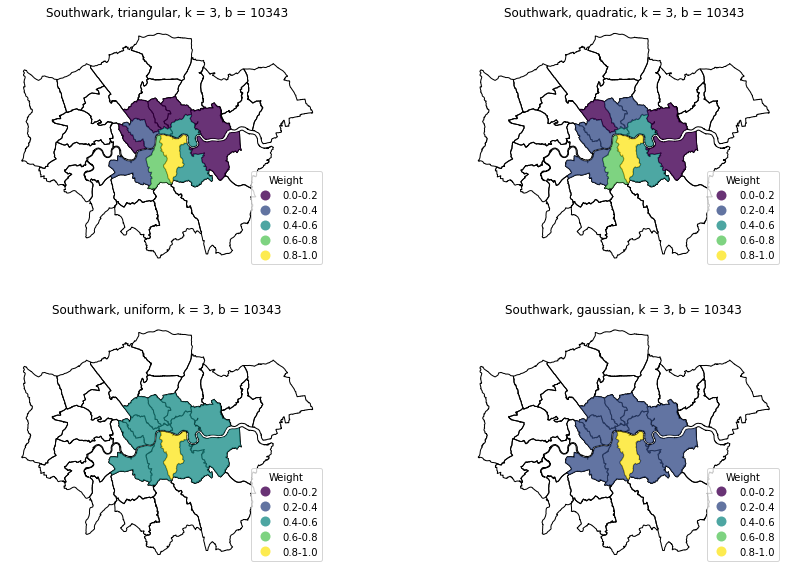

In [67]:
f, axes = plt.subplots(2,2, figsize=(15, 10))

fList = ['triangular','quadratic','uniform','gaussian']

for ax, f in zip(axes.flat, fList):
    myKernel = weights.distance.Kernel.from_dataframe(boros, function=f, k=2, diagonal=True,
                                                      ids=boros['NAME'].tolist())

    plotKernel(myKernel, boros, 'Southwark', ax)

By specifying `diagonal=True` we see that Southwark (the focal location) _always_ has a weight of 1.0. This can be useful in future when working with spatial autocorrelation or regression. 

# Further Activities

- Explore [adaptive bandwidth](https://geographicdata.science/book/notebooks/04_spatial_weights.html#kernel-weights) and [hybrid weights](https://geographicdata.science/book/notebooks/04_spatial_weights.html#distance-bands-and-hybrid-weights) as extensions to the weights methods examined in this notebook
- Continue to read about how spatial weights are used in [Spatial Autocorrelation](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html)
- Investigate other uses of spatial weights, such as [spatial lag](https://darribas.org/gds15/content/labs/lab_06.html#Spatial-lag) 

# Credits!

## Contributors:
The following individual(s) have contributed to these teaching materials: James Millington (james.millington@kcl.ac.uk).

## License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).